# Features Selection MonoVariate

In [1]:
% matplotlib inline

import time
import pandas as pd

from IPython import display as d

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn import feature_selection as fs

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

## 1. Load Data

In [2]:
start = time.time()

path = "/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/"
data = container.read(path)

print("Removing b220...")
del data["b220"]

for df in data.values():
    df["AmplitudeJH"] = df["AmplitudeJ"] - df["AmplitudeH"]
    df["AmplitudeJK"] = df["AmplitudeJ"] - df["Amplitude"]

Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b261.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b263.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b220.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b264.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b262.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b278.npy'...
Removing b220...


##  2. Preprocess

### 2.1. Discretize the classes

In [3]:
data, classes, sclasses = discretize_classes(data)
d.display(d.Markdown("**Classes**"))
d.display(classes)

d.display(d.Markdown("----"))
d.display(d.Markdown("**Simplified Classes**"))
d.display(sclasses)

**Classes**

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

----

**Simplified Classes**

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

### 2.2. Removes all low-variance and "bad" features

In [4]:
X_columns = clean_features(data, "b278")
X_columns = X_columns.drop("AndersonDarling")
X_columns = X_columns[~(X_columns.str.startswith("Freq2_") | X_columns.str.startswith("Freq3_"))]
print("Total features:", X_columns.size)

Removing ['Gskew', 'Period_fit', 'StetsonK'] because null
Removing ['Freq1_harmonics_rel_phase_0', 'Freq2_harmonics_rel_phase_0', 'Freq3_harmonics_rel_phase_0'] because lowvariance
('Total features:', 55)


### 2.3. Selected features

In [5]:
X_columns

Index([u'cnt', u'Amplitude', u'Autocor_length', u'Beyond1Std', u'CAR_mean',
       u'CAR_sigma', u'CAR_tau', u'Con', u'Eta_e', u'FluxPercentileRatioMid20',
       u'FluxPercentileRatioMid35', u'FluxPercentileRatioMid50',
       u'FluxPercentileRatioMid65', u'FluxPercentileRatioMid80',
       u'Freq1_harmonics_amplitude_0', u'Freq1_harmonics_amplitude_1',
       u'Freq1_harmonics_amplitude_2', u'Freq1_harmonics_amplitude_3',
       u'Freq1_harmonics_rel_phase_1', u'Freq1_harmonics_rel_phase_2',
       u'Freq1_harmonics_rel_phase_3', u'LinearTrend', u'MaxSlope', u'Mean',
       u'Meanvariance', u'MedianAbsDev', u'MedianBRP', u'PairSlopeTrend',
       u'PercentAmplitude', u'PercentDifferenceFluxPercentile', u'PeriodLS',
       u'Psi_CS', u'Psi_eta', u'Q31', u'Rcs', u'Skew', u'SmallKurtosis',
       u'Std', u'c89_jk_color', u'c89_hk_color', u'c89_jh_color',
       u'n09_jk_color', u'n09_hk_color', u'n09_jh_color', u'c89_m2', u'c89_m4',
       u'c89_c3', u'n09_m2', u'n09_m4', u'n09_c3', u'A

In [6]:
sclasses

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

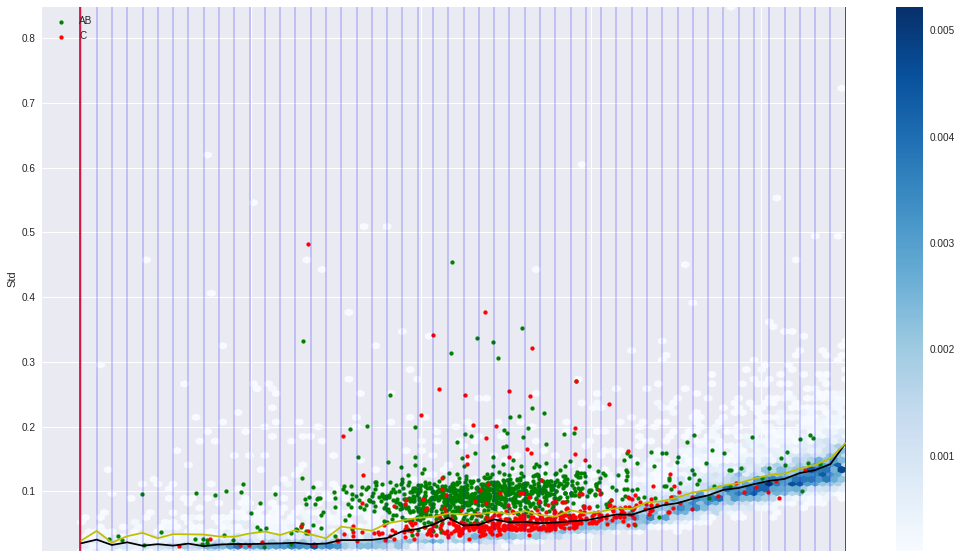

In [7]:
import numpy as np
flt = (12, 16.5)

for k, v in data.items():
    data[k] = v[v.Mean.between(*flt)]

def plot(data):
    all_df = pd.concat(data.values())
    size = len(all_df)

    all_df['C'] = pd.Series(np.ones(size), index=all_df.index)

    unk = all_df[all_df.cls == 0]
    unk_size = len(unk)

    ax = unk.plot.hexbin(
        "Mean", "Std", cmap="Blues", C="C", 
        reduce_C_function=lambda x: (np.sum(x) / unk_size),
        figsize=(18, 10))

    all_df[all_df.cls == 6].plot.scatter("Mean", "Std", s=15, color="g", ax=ax, label="AB")
    all_df[all_df.cls == 7].plot.scatter("Mean", "Std", s=15, color="r", ax=ax, label="C")

    for limit in flt:
        ax.axvline(limit, color="r")


    bins = np.histogram(all_df.Mean, bins=50)[1]

    all_df = all_df.assign(bins=all_df.Mean.apply(np.digitize, bins=bins))

    for idx in bins:
        ax.axvline(idx, color="b", alpha=.2)

    plt.plot(bins, all_df.groupby("bins")["Std"].median(), "k")
    plt.plot(bins, all_df.groupby("bins")["Std"].mean(), "y")

    return ax,bins, all_df.groupby("bins")["Std"].median(), all_df.groupby("bins")["Std"].mean()
    
ax, bins, median, mean = plot(data)

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1816
          3       0.92      0.72      0.81       295

avg / total       0.95      0.95      0.95      2111

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1759
          3       0.92      0.70      0.79       305

avg / total       0.95      0.95      0.94      2064

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1834
          3       0.89      0.77      0.82       221

avg / total       0.96      0.96      0.96      2055

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

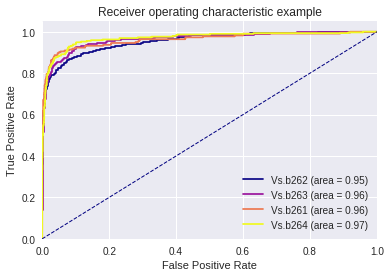

CPU times: user 4.51 s, sys: 93.6 ms, total: 4.61 s
Wall time: 4.49 s


In [8]:
svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='rbf', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
%time roc(svc_poly("b278"))

## Sigma Clip

In [9]:
# raise Exception()

In [10]:
def plot(data):
    all_df = pd.concat(data.values())
    size = len(all_df)

    all_df['C'] = pd.Series(np.ones(size), index=all_df.index)

    unk = all_df[all_df.cls == 0]
    unk_size = len(unk)

    ax = unk.plot.hexbin(
        "Mean", "Std", cmap="Blues", C="C", 
        reduce_C_function=lambda x: (np.sum(x) / unk_size),
        figsize=(18, 10))

    all_df[all_df.cls == 6].plot.scatter("Mean", "Std", s=15, color="g", ax=ax, label="AB")
    all_df[all_df.cls == 7].plot.scatter("Mean", "Std", s=15, color="r", ax=ax, label="C")
    
    return ax

def sclip_g(gid, g, sigmas):
    end = False
    while not end:
        still_keep = g.keep.sum()
        limit = (
            g[g.keep == True].Std.mean() + 
            g[g.keep == True].Std.std() * sigmas)
        keep = ((g.keep == True) & (g.Std <= limit))
        g.keep = keep
        end = (
            still_keep == 0 or 
            still_keep == g.keep.sum())
    return g

def sigma_clip(df, sigmas):
    df = df.copy()
    bins = np.histogram(df.Mean, bins=50)[1]
    df = df.assign(bins=df.Mean.apply(np.digitize, bins=bins))
    df = df.assign(keep=[True for idx in range(len(df))])
    groups = df.groupby("bins")
    marked = pd.concat(sclip_g(gid, g, sigmas) for gid, g in groups)
    scliped = marked[marked.keep == False]
    columns = df.columns[~df.columns.isin(["bins", "keep"])]
    return scliped[columns]

## 1 Sigma Clip

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


[b262] RRLyraes 293/295
[b263] RRLyraes 302/305
[b261] RRLyraes 220/221
[b278] RRLyraes 422/424
[b264] RRLyraes 292/294
b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1507
          3       0.91      0.73      0.81       293

avg / total       0.94      0.94      0.94      1800

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      1396
          3       0.92      0.72      0.80       302

avg / total       0.94      0.94      0.94      1698

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      1506
          3       0.88      0.78      0.83       220

avg / total       0.96      0.96      0.

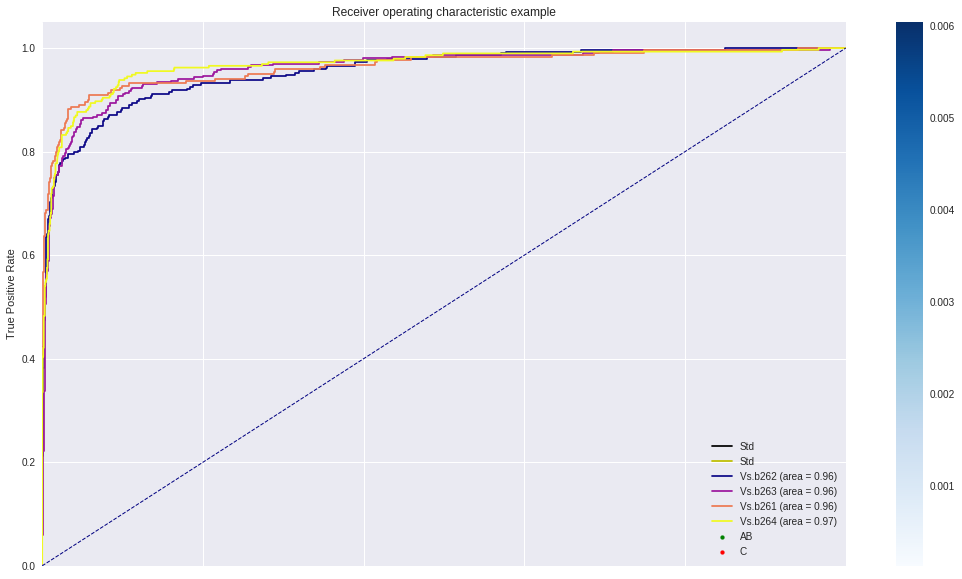

CPU times: user 3.93 s, sys: 220 ms, total: 4.15 s
Wall time: 3.88 s


In [11]:
sclips1 = container.Container()
for k, v in data.items():
    sc = sigma_clip(v, 1)
    sclips1[k] = sc
    print "[{}] RRLyraes {}/{}".format(
        k, len(sc[sc.scls==3]), len(v[v.scls==3]))
    
ax = plot(sclips1)
ax.set_title("1 Sigma clip")
ax.plot(bins, median, "k")
ax.plot(bins, mean, "y")

svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='rbf', probability=True), clsnum=sclasses, 
    data=sclips1, pcls="RRLyr", X_columns=X_columns, y_column="scls")
%time roc(svc_poly("b278"))

## 2 Sigma Clip

[b262] RRLyraes 78/295
[b263] RRLyraes 111/305
[b261] RRLyraes 86/221
[b278] RRLyraes 153/424
[b264] RRLyraes 83/294
b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       274
          3       0.82      0.76      0.79        78

avg / total       0.91      0.91      0.91       352

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.90      0.95      0.92       295
          3       0.83      0.71      0.77       111

avg / total       0.88      0.88      0.88       406

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.96      0.96       293
          3       0.86      0.85      0.85        86

avg / total       0.93      0.93      0.93 

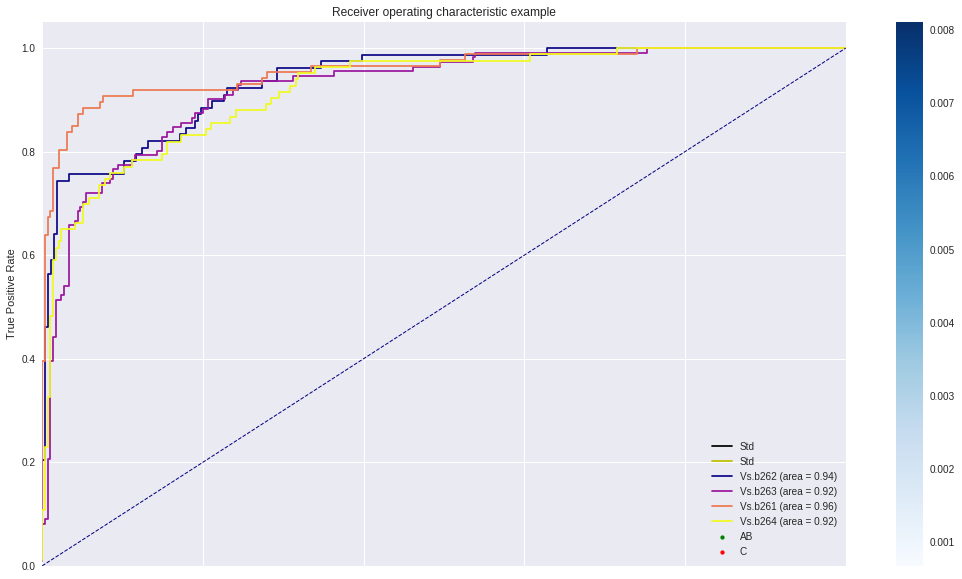

CPU times: user 631 ms, sys: 184 ms, total: 814 ms
Wall time: 543 ms


In [12]:
sclips2 = container.Container()
for k, v in data.items():
    sc = sigma_clip(v, 2)
    sclips2[k] = sc
    print "[{}] RRLyraes {}/{}".format(
        k, len(sc[sc.scls==3]), len(v[v.scls==3]))
    
ax = plot(sclips2)
ax.set_title("2 Sigma clip")
ax.plot(bins, median, "k")
ax.plot(bins, mean, "y")

svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='rbf', probability=True), clsnum=sclasses, 
    data=sclips2, pcls="RRLyr", X_columns=X_columns, y_column="scls")
%time roc(svc_poly("b278"))